In [1]:
from astropy.table import Table
import numpy as np
lens_samples = Table.read('lens_samples.fits')
mask_stack = lens_samples['if_obs_stack'].data
mask_single = lens_samples['if_obs_single'].data

print(np.count_nonzero(mask_stack), np.count_nonzero(mask_single))

11478 7499


In [2]:
z_l = lens_samples['z_l'].data
z_s = lens_samples['z_s0'].data

SNR_g = lens_samples['SNR_g'].data
SNR_r = lens_samples['SNR_r'].data
SNR_i = lens_samples['SNR_i'].data
SNR_z = lens_samples['SNR_z'].data
SNR_stack = lens_samples['SNR_stack'].data

mag_g_s0 = lens_samples['mag_g_s0'].data
mag_r_s0 = lens_samples['mag_r_s0'].data
mag_i_s0 = lens_samples['mag_i_s0'].data
vdisp_l = lens_samples['vdisp_l'].data
mass_s0 = lens_samples['mass_s0'].data
thetaE_s0 = lens_samples['thetaE_s0'].data
mu = lens_samples['mu'].data
best_band = lens_samples['best_band'].data

In [3]:
from scipy.ndimage import gaussian_filter1d
def smooth_hist(data, bins=30, smooth=True, sigma=2, log_bin=False, density=False):
    if log_bin:
        bins = np.logspace(np.log10(np.min(data)), np.log10(np.max(data)),  bins)
        
    counts, bins = np.histogram(data, bins=bins, density=density)
    
    if smooth:
        counts_smoothed = gaussian_filter1d(counts, sigma=sigma)
    else:
        counts_smoothed = counts
        
    #for beautiful step plot
    counts_smoothed = np.insert(counts_smoothed, 0, 0)
    bins = np.insert(bins, 0, bins[0]-1e-3)
    counts_smoothed = np.append(counts_smoothed, 0)
    bins = np.append(bins, bins[-1]+1e-3)
    return counts_smoothed, bins

## Fig.1 Ideal lens plot

In [4]:
from matplotlib import pyplot as plt
from astropy.visualization import hist
import scienceplots
plt.style.use(['science','no-latex', 'nature'])
# plt.style.use(['science','no-latex'])
# Set the font family and size for all text
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
# Set the background color and grid style
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.linewidth'] = 1.5
plt.rcParams['grid.color'] = 'black'
plt.rcParams['grid.alpha'] = 0.5

np.random.seed(1)
hist_size = 5000
z_l_ = np.random.choice(z_l, size=hist_size, replace=False)
z_s_ = np.random.choice(z_s, size=hist_size, replace=False)
vdisp_l_ = np.random.choice(vdisp_l, size=hist_size, replace=False)
thetaE_s0_ = np.random.choice(thetaE_s0, size=hist_size, replace=False)

from SimCsstLens.LensPop.Population import LensPopulation
from SimCsstLens import CosmologyDistance as CD
this_cosmos = CD.CosmosDist(Om0=0.3, Ode0=0.7, h=0.7)
lens_pop = LensPopulation(
    vdisp_floor=100, 
    zl_max=2.0, 
    cosmo_dist=this_cosmos,
    src_catalog_type='lsst',
    bands=['g', 'r', 'i', 'z'],
)
lens_pop.draw_lens_samples(
    nsamples=5000,
    nsrcs_per_sample=1,
    src_over_density=1,
)


columnwidth = 3.33
aspect_ratio = 0.9
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(columnwidth*3+2*0.5, columnwidth*aspect_ratio))

this_ax = axes[0]
data = thetaE_s0_
counts_smoothed, bins = smooth_hist(data)
this_ax.step(bins[:-1], counts_smoothed,  where='post', color='black', label="Stack")
this_ax.set_xlabel(r'$\theta_\mathrm{E} \; \left(\mathrm{arcsec}\right)$')
this_ax.set_ylabel(r'$\rm PDF$')
# this_ax.set_yscale('log')
this_ax.set_yticklabels([])
this_ax.set_xlim(0, 3)
_, ymax = this_ax.get_ylim()
this_ax.set_ylim(0,ymax)

this_ax = axes[1]
data = z_l_
counts_smoothed, bins = smooth_hist(data, density=True)
this_ax.step(bins[:-1], counts_smoothed,  where='post', color='red', label='Foreground deflector')
data = z_s_
counts_smoothed, bins = smooth_hist(data, density=True)
this_ax.step(bins[:-1], counts_smoothed,  where='post', color='blue', label='Background source')
data = lens_pop.dfl_pop.zl_arr
counts_smoothed, bins = smooth_hist(data, density=True, bins=20)
this_ax.step(bins[:-1], counts_smoothed,  where='post', color='red', label='Parent ETG', ls='--')
data = lens_pop.src_pop.zs_arr[0,:]
counts_smoothed, bins = smooth_hist(data, density=True)
this_ax.step(bins[:-1], counts_smoothed,  where='post', color='blue', label='Parent source', ls='--')
this_ax.legend()
this_ax.set_xlabel(r'$\rm z$')
this_ax.set_yticklabels([])
this_ax.set_xlim(0, 6)
_, ymax = this_ax.get_ylim()
this_ax.set_ylim(0,ymax)

this_ax = axes[2]
data = vdisp_l_
counts_smoothed, bins = smooth_hist(data, density=True)
this_ax.step(bins[:-1], counts_smoothed,  where='post', color='black', label='Foreground deflector')
data = lens_pop.dfl_pop.vdisp_arr
counts_smoothed, bins = smooth_hist(data, density=True)
this_ax.step(bins[:-1], counts_smoothed,  where='post', color='black', label='Parent ETG', ls='--')
this_ax.set_xlabel(r'$\sigma_{\mathrm{V}} \; \left(\mathrm{km} \mathrm{s}^{-1}\right)$')
this_ax.legend()
this_ax.set_yticklabels([])
_, ymax = this_ax.get_ylim()
this_ax.set_ylim(0,ymax)

plt.tight_layout()
fig.savefig('figures/ideal_lenses.pdf', bbox_inches='tight')
plt.close(fig)

## Fig.3 SNR plot

In [5]:
from matplotlib import pyplot as plt
from astropy.visualization import hist
import scienceplots
plt.style.use(['science','no-latex', 'nature'])
# plt.style.use(['science','no-latex'])
# Set the font family and size for all text
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
# Set the background color and grid style
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.linewidth'] = 1.5
plt.rcParams['grid.color'] = 'black'
plt.rcParams['grid.alpha'] = 0.5

from astropy.stats import sigma_clip
SNR_stack_ = SNR_stack[mask_stack]
# SNR_stack_ = sigma_clip(SNR_stack_, sigma=3).compressed()

SNR_g_ = SNR_g[mask_single]
SNR_r_ = SNR_r[mask_single]
SNR_i_ = SNR_i[mask_single]
SNR_z_ = SNR_z[mask_single]
best_band_ = best_band[mask_single]
SNR_best_band_ = np.zeros_like(SNR_g_)
for idx in range(len(SNR_g_)):
    if best_band_[idx] == b'g':
        SNR_best_band_[idx] = SNR_g_[idx]
    elif best_band_[idx] == b'r':
        SNR_best_band_[idx] = SNR_r_[idx]
    elif best_band_[idx] == b'i':
        SNR_best_band_[idx] = SNR_i_[idx]
    elif best_band_[idx] == b'z':
        SNR_best_band_[idx] = SNR_z_[idx]
# SNR_best_band_ = sigma_clip(SNR_best_band_, sigma=5).compressed()

columnwidth = 3.33
aspect_ratio = 0.9
fig, axes = plt.subplots(figsize=(columnwidth, columnwidth*aspect_ratio))
data = SNR_stack_
counts_smoothed, bins = smooth_hist(data, log_bin=True)
axes.step(bins[:-1], counts_smoothed,  where='post', color='black', label='Stack')
data = SNR_best_band_
counts_smoothed, bins = smooth_hist(data, log_bin=True)
axes.step(bins[:-1], counts_smoothed,  where='post', color='black', ls='--', label='Single')
axes.set_xlabel(r'Arc SNR')
axes.set_ylabel(r'N')
axes.set_yscale('log')
axes.set_xscale('log')
axes.legend()
_, xmax = axes.get_xlim()
axes.set_xlim(20,xmax)
_, ymax = axes.get_ylim()
axes.set_ylim(1,ymax)
plt.tight_layout()
fig.savefig('figures/arc_snr.pdf', bbox_inches='tight')
plt.close(fig)

## Fig.4 Lensing properties plot

In [6]:
from matplotlib import pyplot as plt
from astropy.visualization import hist
import scienceplots
plt.style.use(['science','no-latex', 'nature'])
# plt.style.use(['science','no-latex'])
# Set the font family and size for all text
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
# Set the background color and grid style
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.linewidth'] = 1.5
plt.rcParams['grid.color'] = 'black'
plt.rcParams['grid.alpha'] = 0.5

columnwidth = 3.33
aspect_ratio = 0.9
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(columnwidth*2+0.5, columnwidth*aspect_ratio*2+0.5))


this_ax = axes[0,0]
data = z_l[mask_stack]
counts_smoothed, bins = smooth_hist(data)
this_ax.step(bins[:-1], counts_smoothed,  where='post', color='red', label="Lens-Stack")
data = z_s[mask_stack]
counts_smoothed, bins = smooth_hist(data)
this_ax.step(bins[:-1], counts_smoothed,  where='post', color='blue', label="Source-Stack")
data = z_l[mask_single]
counts_smoothed, bins = smooth_hist(data)
this_ax.step(bins[:-1], counts_smoothed,  where='post', color='red', label="Lens-Single", ls='--')
data = z_s[mask_single]
counts_smoothed, bins = smooth_hist(data)
this_ax.step(bins[:-1], counts_smoothed,  where='post', color='blue', label="Source-Single", ls='--')
this_ax.set_xlabel(r'z')
this_ax.set_ylabel(r'N')
_, ymax = this_ax.get_ylim()
this_ax.set_ylim(0,ymax)
this_ax.legend()

this_ax = axes[0,1]
data = mass_s0[mask_stack]
counts_smoothed, bins = smooth_hist(data, log_bin=True)
this_ax.step(bins[:-1], counts_smoothed,  where='post', color='black', label="Stack")
data = mass_s0[mask_single]
counts_smoothed, bins = smooth_hist(data, log_bin=True)
this_ax.step(bins[:-1], counts_smoothed,  where='post', color='black', label="Single", ls='--')
this_ax.legend()
this_ax.set_xlabel(r'Einstein Mass')
this_ax.set_xscale('log')
_, ymax = this_ax.get_ylim()
this_ax.set_ylim(0,ymax)

this_ax = axes[1,0]
data = mu[mask_stack]
counts_smoothed, bins = smooth_hist(data, log_bin=True)
# counts_smoothed, bins = smooth_hist(data, bins=25, smooth=False)
this_ax.step(bins[:-1], counts_smoothed,  where='post', color='black', label="Stack")
data = mu[mask_single]
counts_smoothed, bins = smooth_hist(data, log_bin=True)
# counts_smoothed, bins = smooth_hist(data, bins=25, smooth=False)
this_ax.step(bins[:-1], counts_smoothed,  where='post', color='black', label="Single", ls='--')
this_ax.legend()
this_ax.set_xlabel('$\mu$')
this_ax.set_ylabel(r'N')
this_ax.set_xscale('log')
this_ax.set_yscale('log')
_, xmax = this_ax.get_xlim()
this_ax.set_xlim(3,xmax)

this_ax = axes[1,1]
data = mag_g_s0[mask_stack]
counts_smoothed, bins = smooth_hist(data)
this_ax.step(bins[:-1], counts_smoothed,  where='post', color='black', label="Stack")
data = mag_g_s0[mask_single]
counts_smoothed, bins = smooth_hist(data)
this_ax.step(bins[:-1], counts_smoothed,  where='post', color='black', label="Single", ls='--')
this_ax.legend()
this_ax.set_xlabel(r'$\rm mag^{src}_g$')
this_ax.set_xlim(20,30)
_, ymax = this_ax.get_ylim()
this_ax.set_ylim(0,ymax)

plt.tight_layout()
fig.savefig('figures/lensing_properties.pdf', bbox_inches='tight')
plt.close(fig)

## Fig.5 LSST, Euclid, CSST

In [7]:
from matplotlib import pyplot as plt
from astropy.visualization import hist
import scienceplots
plt.style.use(['science','no-latex', 'nature'])
# plt.style.use(['science','no-latex'])
# Set the font family and size for all text
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
# Set the background color and grid style
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.linewidth'] = 1.5
plt.rcParams['grid.color'] = 'black'
plt.rcParams['grid.alpha'] = 0.5

lsst_samples = Table.read('lenses_LSSTc.txt',  format='ascii')
euclid_samples = Table.read('lenses_Euclid.txt',  format='ascii')

thetaE_lsst = lsst_samples['col3'].data
vdisp_lsst = lsst_samples['col4'].data
thetaE_euclid = euclid_samples['col3'].data
vdisp_euclid = euclid_samples['col4'].data

thetaE_csst = lens_samples[mask_stack]['thetaE_s0'].data
vdisp_csst = lens_samples[mask_stack]['vdisp_l'].data

columnwidth = 3.33
aspect_ratio = 0.9
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(columnwidth*2+0.5, columnwidth*aspect_ratio))

this_ax = axes[0]
data = thetaE_csst
counts_smoothed, bins = smooth_hist(data)
this_ax.step(bins[:-1], counts_smoothed,  where='post', color='black', label="CSST")
data = thetaE_euclid
counts_smoothed, bins = smooth_hist(data)
counts_smoothed = counts_smoothed * 15000/(41252.96*0.1)
this_ax.step(bins[:-1], counts_smoothed,  where='post', color='red', label="Euclid")
data = thetaE_lsst
counts_smoothed, bins = smooth_hist(data)
counts_smoothed = counts_smoothed * 20000/(41252.96*0.1)
this_ax.step(bins[:-1], counts_smoothed,  where='post', color='blue', label="LSST")
this_ax.legend()
this_ax.set_xlabel(r'$\theta_\mathrm{E}$')
this_ax.set_ylabel(r'N')
_, ymax = this_ax.get_ylim()
this_ax.set_ylim(0,ymax)
this_ax.set_xlim(0, 3.5)

this_ax = axes[1]
data = vdisp_csst
counts_smoothed, bins = smooth_hist(data)
this_ax.step(bins[:-1], counts_smoothed,  where='post', color='black', label="CSST")
data = vdisp_euclid
counts_smoothed, bins = smooth_hist(data)
counts_smoothed = counts_smoothed * 15000/(41252.96*0.1)
this_ax.step(bins[:-1], counts_smoothed,  where='post', color='red', label="Euclid")
data = vdisp_lsst
counts_smoothed, bins = smooth_hist(data)
counts_smoothed = counts_smoothed * 20000/(41252.96*0.1)
this_ax.step(bins[:-1], counts_smoothed,  where='post', color='blue', label="LSST")
this_ax.legend()
this_ax.set_xlabel(r'$\sigma_\mathrm{v}$')
_, ymax = this_ax.get_ylim()
this_ax.set_ylim(0,ymax)

plt.tight_layout()
fig.savefig('figures/csst_euclid_lsst.pdf', bbox_inches='tight')
plt.close(fig)


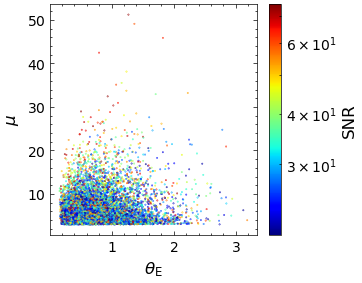

/tmp/ipykernel_127264/1555745971.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(arc_snr_, mu_, s=0.1, alpha=1, marker='o', cmap='jet')


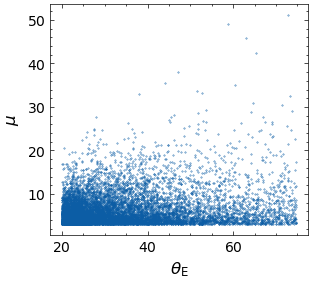

In [8]:
from matplotlib.colors import LogNorm

thetaE_ = thetaE_s0[mask_stack]
mu_ = mu[mask_stack]
arc_snr_ = SNR_stack[mask_stack]

from astropy.stats import sigma_clip
arc_snr_ = sigma_clip(arc_snr_, sigma=3)


columnwidth = 3.33
aspect_ratio = 0.9
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(columnwidth, columnwidth*aspect_ratio))
plt.scatter(thetaE_, mu_, c=arc_snr_, s=0.1, alpha=1, marker='o', cmap='jet', norm=LogNorm())
cbar = plt.colorbar()
cbar.set_label('SNR')
plt.xlabel(r'$\theta_{\rm E}$')
plt.ylabel(r'$\mu$')
plt.subplots_adjust()
plt.show()


columnwidth = 3.33
aspect_ratio = 0.9
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(columnwidth, columnwidth*aspect_ratio))
plt.scatter(arc_snr_, mu_, s=0.1, alpha=1, marker='o', cmap='jet')
plt.xlabel(r'$\theta_{\rm E}$')
plt.ylabel(r'$\mu$')
plt.subplots_adjust()
plt.show()